# Importing all the required libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


# Loading the Data

In [3]:
# input_folder = r"\Clustered Frequencies"
input_folder=r"E:\AUB\Research Bakarji\LAYAN\OudDatasetOrganisedbyMaqam-20250211T174612Z-001\Clustered Frequencies"
# --- Maqam types ---
maqam_types = ['kurd', 'nahawand', 'segah', 'hijaz', 'rast', 'saba', 'hijazkar', 'bayat']

# --- Load frequencies, durations, and maqam types from files ---
frequencies, durations, maqam_type_labels = [], [], []

for filename in os.listdir(input_folder):
    if filename.endswith('.npz'):
        maqam_type = next((m for m in maqam_types if filename.lower().startswith(m)), None)
        if maqam_type:
            try:
                data = np.load(os.path.join(input_folder, filename))
                freq_array = data['frequencies'].astype(float).tolist()
                dur_array = data['durations'].astype(int).tolist()
                frequencies.append(freq_array)
                durations.append(dur_array)
                maqam_type_labels.append(maqam_type)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"Unknown maqam type in file: {filename}")


# --- Frequency preprocessing ---
all_frequencies = np.concatenate([np.array(lst) for lst in frequencies])
filtered = all_frequencies[(all_frequencies >= 50) & (all_frequencies <= 400)]
sorted_filtered = np.sort(filtered)
selected = [sorted_filtered[0]]
for i in range(1, len(sorted_filtered)):
    if sorted_filtered[i] - selected[-1] > 0.5:
        selected.append(sorted_filtered[i])
reference_frequencies = np.array(selected)
reference_durations = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 80, 100, 150, 200, 250, 300])

def project_to_nearest_reference(input_list, reference):
    input_list = np.array(input_list)
    indices = np.abs(input_list[:, None] - reference).argmin(axis=1)
    return reference[indices]

# --- Reload and project all data ---
frequencies, durations, maqam_type_labels = [], [], []
for filename in os.listdir(input_folder):
    if filename.endswith('.npz'):
        maqam_type = next((m for m in maqam_types if filename.lower().startswith(m)), None)
        if maqam_type:
            try:
                data = np.load(os.path.join(input_folder, filename))
                projected_freq_array = project_to_nearest_reference(data['frequencies'].astype(float), reference_frequencies)
                projected_dur_array = project_to_nearest_reference(data['durations'].astype(int), reference_durations)
                frequencies.append(projected_freq_array.tolist())
                durations.append(projected_dur_array.tolist())
                maqam_type_labels.append(maqam_type)
            except Exception as e:
                print(f"Error loading {filename}: {e}")

# Building the Tokenizer

In [4]:

# --- Token dictionaries ---
def create_combined_tokenization_dictionaries(maqam_types, unique_freqs, unique_durations):
    token_to_value = {0: "PAD", 1: "UNK"}
    value_to_token = {"PAD": 0, "UNK": 1}
    current_index = 2
    for m in maqam_types:
        token_to_value[current_index] = m
        value_to_token[m] = current_index
        current_index += 1
    for f in unique_freqs:
        freq_token = f"freq_{round(f, 2)}"
        token_to_value[current_index] = freq_token
        value_to_token[freq_token] = current_index
        current_index += 1
    for d in unique_durations:
        dur_token = f"duration_{int(d)}"
        token_to_value[current_index] = dur_token
        value_to_token[dur_token] = current_index
        current_index += 1
    token_to_value[current_index] = "EOS"
    value_to_token["EOS"] = current_index
    return token_to_value, value_to_token



def build_token_sequences(type_tokens, freq_tokens, dur_tokens, target_length=None, pad_token=0, eos_token=None):
    assert len(type_tokens) == len(freq_tokens) == len(dur_tokens)
    token_sequences = []
    for t, freqs, durs in zip(type_tokens, freq_tokens, dur_tokens):
        assert len(freqs) == len(durs)
        max_pairs = ((target_length - 2) // 2) if target_length else None
        i = 0
        while i < len(freqs):
            seq = [t]
            end = i + max_pairs if max_pairs else len(freqs)
            for f, d in zip(freqs[i:end], durs[i:end]):
                f_token = value_to_token.get(f"freq_{round(float(f), 2)}", 1)
                d_token = value_to_token.get(f"duration_{int(d)}", 1)
                seq.extend([f_token, d_token])
            i = end
            if eos_token is not None and i >= len(freqs):
                if target_length is None or len(seq) + 1 <= target_length:
                    seq.append(eos_token)
            if target_length and len(seq) < target_length:
                seq += [pad_token] * (target_length - len(seq))
            token_sequences.append(seq)
    return token_sequences

token_to_value, value_to_token = create_combined_tokenization_dictionaries(maqam_types, reference_frequencies, reference_durations)
eos_token = value_to_token["EOS"]


type_tokens = [value_to_token[m] for m in maqam_type_labels]
sequences = build_token_sequences(type_tokens, frequencies, durations, target_length=1024, pad_token=0, eos_token=eos_token)


# Splitting the Data into train, test and validation sets

In [5]:

# --- Data split ---
train_data, temp_data = train_test_split(sequences, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


# Creating a Data loader

In [6]:

# --- Dataset & Dataloader ---
class Pitch_Dataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        input_sequence = sequence[:-1]
        target_sequence = sequence[1:]
        return torch.tensor(input_sequence), torch.tensor(target_sequence)
# --- Configuration ---
context_size=1024
batch_size=4

train_dataset = Pitch_Dataset(train_data, context_size)
val_dataset = Pitch_Dataset(val_data, context_size)
test_dataset = Pitch_Dataset(test_data, context_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Encoder Only Model

c:\Users\Administrator\miniconda3\envs\torch-cuda\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 001: Train=5.0888, Val=4.5139, Test=4.5209
Epoch 002: Train=4.3511, Val=4.2656, Test=4.2675
Epoch 003: Train=4.1476, Val=4.1693, Test=4.1760
Epoch 004: Train=4.0532, Val=4.1194, Test=4.1314
Epoch 005: Train=4.0000, Val=4.0932, Test=4.1108
Epoch 006: Train=3.9673, Val=4.0779, Test=4.1033
Epoch 007: Train=3.9422, Val=4.0698, Test=4.1041
Epoch 008: Train=3.9216, Val=4.0622, Test=4.1116
Epoch 009: Train=3.9045, Val=4.0586, Test=4.1200
Epoch 010: Train=3.8900, Val=4.0549, Test=4.1357
Epoch 011: Train=3.8820, Val=4.0573, Test=4.1247
Epoch 012: Train=3.8592, Val=4.0550, Test=4.1592
Epoch 013: Train=3.8443, Val=4.0511, Test=4.1546
Epoch 014: Train=3.8279, Val=4.0510, Test=4.1694
Epoch 015: Train=3.8089, Val=4.0566, Test=4.1682
Epoch 016: Train=3.7894, Val=4.0575, Test=4.1867
Epoch 017: Train=3.7700, Val=4.0718, Test=4.1844
Epoch 018: Train=3.7499, Val=4.0767, Test=4.2095
Epoch 019: Train=3.7304, Val=4.0930, Test=4.2134
Epoch 020: Train=3.7111, Val=4.1053, Test=4.2379
Epoch 021: Train=3.6

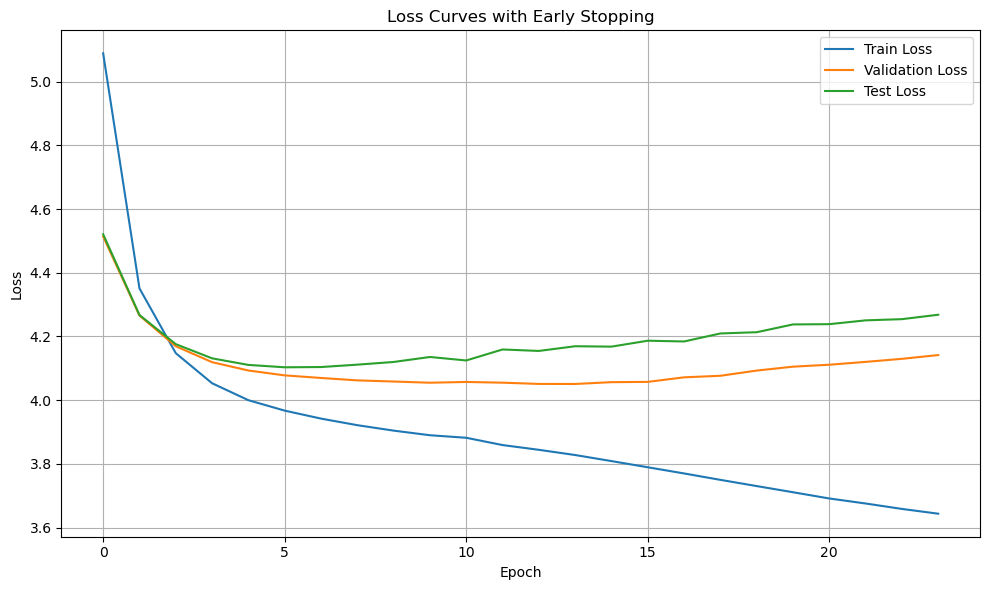

In [7]:

# ---Auto Regressive Model ---
class AutoregressiveTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, hidden_dim, max_len=512, dropout=0.2):
        super().__init__()
        self.type_embedding = nn.Embedding(14, embed_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Embedding(max_len, embed_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, hidden_dim, dropout),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        seq_len, batch_size = x.size()

        # Token type embedding
        token_types = torch.zeros_like(x)
        token_types[x < 10] = x[x < 10]
        token_types[(x >= 10) & (x <= vocab_size - 18)] = 11
        token_types[(x >= vocab_size - 17) & (x <= vocab_size - 2)] = 12
        token_types[x == vocab_size - 1] = 13

        type_embeddings = self.type_embedding(token_types)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(1).expand(seq_len, batch_size)
        pos_encoding = self.positional_encoding(positions)
        embeddings = self.embedding(x) + pos_encoding + type_embeddings
        embeddings = self.dropout(embeddings)
        transformer_output = self.transformer(embeddings)
        return self.fc_out(transformer_output)

# --- Training ---

# --- Training Setup ---
# Define hyperparameters
vocab_size = len(token_to_value)
embed_size = 256
num_heads = 8
num_layers = 6
hidden_dim = 256
seq_length = context_size
num_epochs = 100
learning_rate = 0.0001
n_patience = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoregressiveTransformer(vocab_size, embed_size, num_heads, num_layers, hidden_dim, max_len=seq_length).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=n_patience)

train_losses, val_losses, test_losses = [], [], []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_seq, target_seq in train_loader:
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input_seq, target_seq in val_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # --- Test ---
    test_loss = 0.0
    with torch.no_grad():
        for input_seq, target_seq in test_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1:03d}: Train={train_loss:.4f}, Val={val_loss:.4f}, Test={test_loss:.4f}")
    scheduler.step(val_loss)

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= n_patience:
            print("Early stopping triggered.")
            break

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
def generate_sequence(model, seed, max_length=128, eos_token=452, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    generated = seed[:]  # Start with the seed tokens

    with torch.no_grad():
        for _ in range(max_length - len(seed)):
            # Prepare input
            input_seq = torch.tensor(generated, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)
            
            # Get model output
            logits = model(input_seq)  # (1, seq_len, vocab_size)
            next_token_logits = logits[0, -1, :]  # Last token's output

            # Sample or pick the most probable token
            next_token = torch.argmax(next_token_logits).item()

            # Append to sequence
            generated.append(next_token)

            # Stop if EOS is predicted
            if next_token == eos_token:
                break

    return generated
# Example: Generate from a known seed (like a Maqam type token and first freq/dur pair)
# example_seed = [value_to_token["kurd"], value_to_token["freq_67.6"], value_to_token["duration_50"]]
example_seed=[4,23,312,49,250,72,315,194]
# Generate a continuation
generated_tokens = generate_sequence(model, example_seed, max_length=128)

# Convert back to readable tokens
# generated_human_readable = detokenize_combined(generated_tokens, token_to_value)

print("Generated token IDs:", generated_tokens)
# print("Decoded sequence:", generated_human_readable)


Generated token IDs: [4, 23, 312, 49, 250, 72, 315, 194, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210, 372, 210]


# Decoder ONLY

Epoch 001: Train=5.1272, Val=4.7286, Test=4.6947
Epoch 002: Train=4.4811, Val=4.3392, Test=4.2854
Epoch 003: Train=4.1868, Val=4.2079, Test=4.1630
Epoch 004: Train=4.0682, Val=4.1499, Test=4.1186
Epoch 005: Train=4.0094, Val=4.1211, Test=4.0992
Epoch 006: Train=3.9766, Val=4.1041, Test=4.0884
Epoch 007: Train=3.9512, Val=4.0932, Test=4.0827
Epoch 008: Train=3.9302, Val=4.0794, Test=4.0730
Epoch 009: Train=3.9014, Val=4.0565, Test=4.0570
Epoch 010: Train=3.8589, Val=4.0325, Test=4.0407
Epoch 011: Train=3.7989, Val=3.9737, Test=3.9980
Epoch 012: Train=3.7168, Val=3.9061, Test=3.9485
Epoch 013: Train=3.6280, Val=3.8346, Test=3.8885
Epoch 014: Train=3.5396, Val=3.7721, Test=3.8509
Epoch 015: Train=3.4642, Val=3.6932, Test=3.8197
Epoch 016: Train=3.3929, Val=3.6407, Test=3.7957
Epoch 017: Train=3.3202, Val=3.6074, Test=3.7685
Epoch 018: Train=3.2490, Val=3.5457, Test=3.7271
Epoch 019: Train=3.1778, Val=3.4931, Test=3.6792
Epoch 020: Train=3.1184, Val=3.4503, Test=3.6293
Epoch 021: Train=3.0

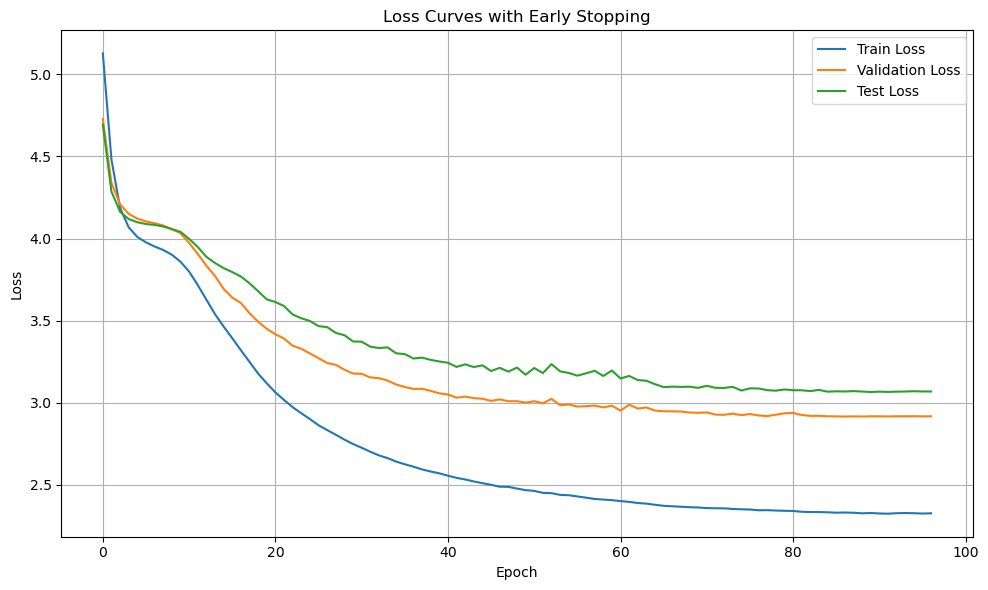

In [9]:

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, hidden_dim, max_len=512, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_len, embed_size)
        self.type_embedding = nn.Embedding(14, embed_size)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.ln_f = nn.LayerNorm(embed_size)
        self.head = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len = x.size()
        device = x.device

        # Token type embedding
        token_types = torch.zeros_like(x)
        token_types[x < 10] = x[x < 10]
        token_types[(x >= 10) & (x <= vocab_size - 18)] = 11
        token_types[(x >= vocab_size - 17) & (x <= vocab_size - 2)] = 12
        token_types[x == vocab_size - 1] = 13

        # Embeddings
        token_embed = self.embedding(x)
        type_embed = self.type_embedding(token_types)
        pos_ids = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
        pos_embed = self.pos_embedding(pos_ids)
        x = self.dropout(token_embed + type_embed + pos_embed)

        # Causal mask
        mask = torch.triu(
            torch.full((seq_len, seq_len), float('-inf'), device=device),
            diagonal=1
        )
        
        # Transformer
        out = self.transformer(x, mask)
        out = self.ln_f(out)
        logits = self.head(out)
        return logits  


# --- Training Setup ---
# Define hyperparameters
vocab_size = len(token_to_value)
embed_size = 256
num_heads = 8
num_layers = 6
hidden_dim = 256
seq_length = context_size
num_epochs = 100
learning_rate = 0.0001
n_patience = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(token_to_value)
model = DecoderOnlyTransformer(vocab_size, embed_size, num_heads, num_layers, hidden_dim, max_len=seq_length,dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

train_losses, val_losses, test_losses = [], [], []
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_seq, target_seq in train_loader:
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input_seq, target_seq in val_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # --- Test ---
    test_loss = 0.0
    with torch.no_grad():
        for input_seq, target_seq in test_loader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            output = model(input_seq)
            loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1:03d}: Train={train_loss:.4f}, Val={val_loss:.4f}, Test={test_loss:.4f}")
    scheduler.step(val_loss)

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
def generate_sequence(model, seed, max_length=128, eos_token=452, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    generated = seed[:]  # Start with the seed tokens

    with torch.no_grad():
        for _ in range(max_length - len(seed)):
            # Prepare input
            input_seq = torch.tensor(generated, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)
            
            # Get model output
            logits = model(input_seq)  # (1, seq_len, vocab_size)
            next_token_logits = logits[0, -1, :]  # Last token's output

            # Sample or pick the most probable token
            next_token = torch.argmax(next_token_logits).item()

            # Append to sequence
            generated.append(next_token)

            # Stop if EOS is predicted
            if next_token == eos_token:
                break

    return generated

example_seed=[6,23,370,145,376,158,378,224,380,117,369,229,370,169,377]
# Generate a continuation
generated_tokens = generate_sequence(model, example_seed, max_length=128)

print("Generated token IDs:",generated_tokens)

Generated token IDs: [6, 23, 370, 145, 376, 158, 378, 224, 380, 117, 369, 229, 370, 169, 377, 370, 372, 370, 372, 370, 373, 370, 373, 370, 372, 370, 372, 370, 372, 370, 372, 370, 373, 370, 372, 370, 373, 370, 372, 370, 372, 370, 373, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 373, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370, 372, 370]


In [ ]:
import numpy as np
import re
import sounddevice as sd
from scipy.signal import sawtooth
from scipy.io.wavfile import write as write_wav
sample_rate=22000
freq=[]
duration=[]
#extracting all the frequencies and durations from the generated sequence
for i in generated_tokens:
    token=value_to_token(i)
    match = re.search(r'_(\d+\.?\d*)$', token)

    if match:
        value = match.group(1)
        if '.' in value:
            freq.append(float(value))
        else:
            duration.append(int(value)) # Save as integer
    

def generate_tone(freq, duration, sample_rate=22050, fade_duration=0.01):
    num_samples = int(sample_rate * duration)
    if num_samples < 2:
        return np.zeros(1)

    t = np.linspace(0, duration, num_samples, endpoint=False)
    wave = sawtooth(2 * np.pi * freq * t, 0.5)

    fade_samples = int(sample_rate * fade_duration)
    fade_samples = min(fade_samples, num_samples // 2)

    if fade_samples > 0:
        fade_in = np.linspace(0, 1, fade_samples)
        fade_out = np.linspace(1, 0, fade_samples)
        wave[:fade_samples] *= fade_in
        wave[-fade_samples:] *= fade_out

    return wave
# Transforming the notes into sawtooth wave and synthetizing them into a wav file

notes = [(f, d) for f, d in zip(freq, duration)]

# Generate waveform
full_wave = np.concatenate([generate_tone(freq, dur, sample_rate) for freq, dur in notes])

# Normalize and scale to 16-bit PCM range
full_wave /= np.max(np.abs(full_wave))  # Normalize to [-1, 1]
scaled_wave = np.int16(full_wave * 32767)  # Convert to 16-bit

# Save to WAV
wav_filename = r"E:\LLM_Output2_wave.wav"
write_wav(wav_filename, sample_rate, scaled_wave)
print(f"WAV file saved as: {wav_filename}")

# Play the sound
# sd.play(0.2 * full_wave, sample_rate)
# sd.wait()


WAV file saved as: E:\LLM_Output2_wave.wav
